In [1]:
# === Library Utama ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# === Preprocessing dan Evaluasi ===
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error, mean_absolute_error
import skfuzzy as fuzz
warnings.filterwarnings("ignore", category=FutureWarning)

# ===  Pengaturan Visualisasi ===
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "axes.edgecolor": "gray",
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": 0.6,
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "DejaVu Sans"],
    "figure.figsize": (8, 5),
    "legend.frameon": True,
    "legend.loc": "best",
    "xtick.labelsize": 10,
    "ytick.labelsize": 10})

# Bangkitkan Data

In [2]:
np.random.seed(17)
n = 300

courses = [
    "Teori Statistika", "Pemrograman Statistika", "Analisis Statistika",
    "Analisis Deret Waktu", "Analisis Data Kategorik", "Metode Penarikan Contoh",
    "Rancangan Percobaan", "Analisis Data Spasial", "Pemodelan Klasifikasi"]

# Simulasi nilai dengan sebaran berbeda per matkul
def simulate_grades(course, size):
    if course == "Teori Statistika":
        grades = np.random.normal(3.55, 0.20, size)
    elif course == "Pemrograman Statistika":
        grades = np.random.gamma(8, 0.4, size)
    elif course == "Analisis Statistika":
        grades = np.random.beta(8, 2, size) * 1.5 + 2.5
    elif course == "Analisis Deret Waktu":
        grades = np.random.lognormal(mean=1.2, sigma=0.15, size=size)
        grades = (grades - grades.min()) / (grades.max() - grades.min()) * 1.5 + 2.5
    elif course == "Analisis Data Kategorik":
        grades = np.random.normal(3.8, 0.25, size)
    elif course == "Metode Penarikan Contoh":
        grades = np.random.beta(6, 3, size) * 1.3 + 2.7
    elif course == "Rancangan Percobaan":
        grades = np.random.gamma(7, 0.38, size)
    elif course == "Analisis Data Spasial":
        grades = np.random.normal(3.6, 0.18, size)
    elif course == "Pemodelan Klasifikasi":
        grades = np.random.lognormal(mean=1.25, sigma=0.13, size=size)
        grades = (grades - grades.min()) / (grades.max() - grades.min()) * 1.5 + 2.5
    else:
        grades = np.random.normal(3.5, 0.2, size)
    return np.clip(grades, 2.5, 4.0)

data = {course: simulate_grades(course, n) for course in courses}
df = pd.DataFrame(data)
df["IPK"] = df[courses].sum(axis=1) / len(courses)
df["IPK"] = df["IPK"].clip(2.75, 3.95)

def insert_missing_mcar(df_full, prop_missing=0.1):
    df_missing = df_full.copy()
    n_rows, n_cols = df_missing.shape
    total = n_rows * (n_cols - 1)  # kecuali IPK
    n_missing = int(total * prop_missing)
    for _ in range(n_missing):
        i = np.random.randint(0, n_rows)
        j = np.random.randint(0, n_cols - 1)
        df_missing.iat[i, j] = np.nan
    return df_missing

df_missing = insert_missing_mcar(df, 0.15).round(2)
df_missing

,Teori Statistika,Pemrograman Statistika,Analisis Statistika,Analisis Deret Waktu,Analisis Data Kategorik,Metode Penarikan Contoh,Rancangan Percobaan,Analisis Data Spasial,Pemodelan Klasifikasi,IPK
0,3.61,NaN,3.68,3.35,3.79,3.40,2.93,3.90,2.94,3.51
1,3.18,2.96,3.61,3.44,3.83,3.79,2.50,3.29,2.90,3.28
2,3.67,2.93,3.72,3.47,4.00,3.40,2.50,3.36,2.60,3.29
3,3.78,3.70,3.62,3.29,3.63,NaN,NaN,3.27,3.29,3.42
4,3.76,2.50,3.70,3.41,NaN,3.15,2.50,3.72,2.84,3.25
...,...,...,...,...,...,...,...,...,...,...
295,NaN,2.50,3.71,3.24,4.00,NaN,NaN,3.73,3.21,3.53
296,3.53,3.78,NaN,2.98,3.74,3.69,2.50,3.76,NaN,3.39
297,3.40,2.50,3.47,2.85,3.77,3.79,2.52,3.80,2.72,3.20
298,3.00,NaN,3.58,3.11,4.00,3.72,2.50,3.48,2.77,3.22


In [ ]:
#df_missing.to_csv("datahilang_df.csv", index=False)

## Stat Desc

In [4]:
# Statistik deskriptif
stat_desc = df_missing.describe().T
stat_desc["N Missing"] = df_missing.isna().sum()
stat_desc["% Missing"] = 100 * stat_desc["N Missing"] / len(df_missing)
display(stat_desc.round(2))

,count,mean,std,min,25%,50%,75%,max,N Missing,% Missing
Teori Statistika,259.0,3.55,0.20,2.87,3.41,3.56,3.70,4.00,41,13.67
Pemrograman Statistika,260.0,3.23,0.60,2.50,2.50,3.18,3.90,4.00,40,13.33
Analisis Statistika,268.0,3.68,0.18,3.04,3.59,3.70,3.82,3.96,32,10.67
Analisis Deret Waktu,256.0,3.26,0.27,2.50,3.07,3.26,3.44,3.99,44,14.67
Analisis Data Kategorik,255.0,3.78,0.18,3.21,3.66,3.80,3.95,4.00,45,15.00
Metode Penarikan Contoh,257.0,3.57,0.20,2.99,3.44,3.59,3.73,3.94,43,14.33
Rancangan Percobaan,256.0,2.92,0.53,2.50,2.50,2.64,3.18,4.00,44,14.67
Analisis Data Spasial,266.0,3.60,0.19,3.11,3.46,3.59,3.74,4.00,34,11.33
Pemodelan Klasifikasi,252.0,3.03,0.27,2.50,2.84,3.01,3.23,3.93,48,16.00
IPK,300.0,3.40,0.10,3.15,3.33,3.39,3.47,3.72,0,0.00


## Visualisasi 

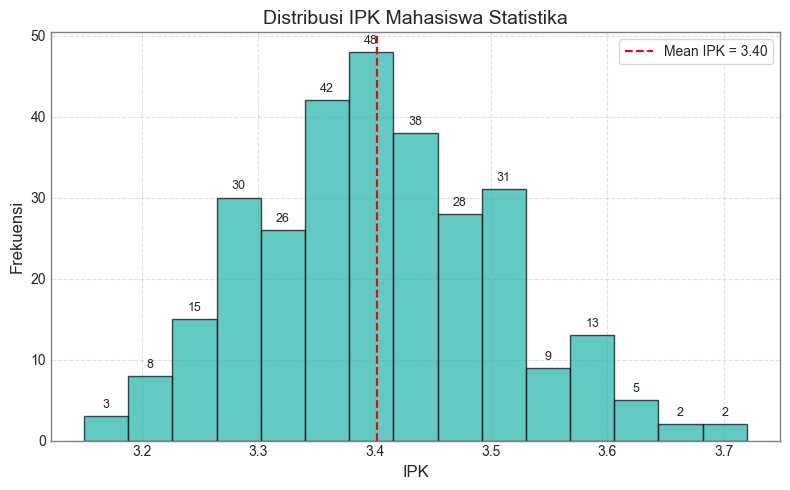

In [5]:
# Sebaran IPK Histogram
plt.figure(figsize=(8, 5))
n, bins, patches = plt.hist(df_missing["IPK"], bins=15, color='lightseagreen', edgecolor='black', alpha=0.7)
plt.axvline(df_missing["IPK"].mean(), color='red', linestyle='--', label=f"Mean IPK = {df_missing['IPK'].mean():.2f}")
plt.title("Distribusi IPK Mahasiswa Statistika", fontsize=14)
plt.xlabel("IPK")
plt.ylabel("Frekuensi")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

for i in range(len(patches)):
    plt.text(patches[i].get_x() + patches[i].get_width()/2, n[i] + 1, str(int(n[i])), ha='center', fontsize=9)
plt.tight_layout()
plt.show()

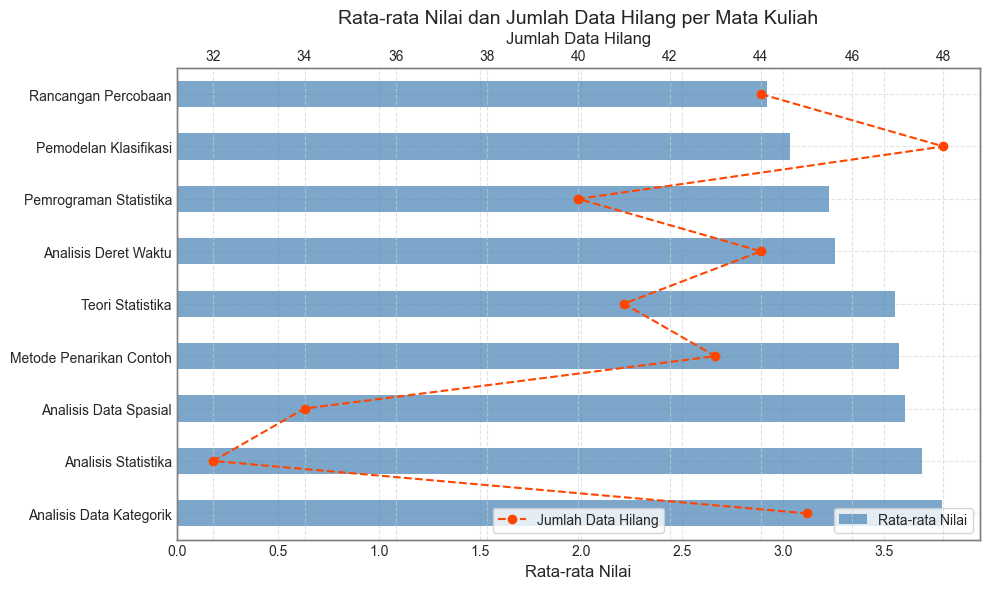

In [6]:
# Barplot Sumbu Ganda
avg_per_course = df_missing[courses].mean().sort_values()
missing_per_course = df_missing[courses].isna().sum()[avg_per_course.index]
fig, ax1 = plt.subplots(figsize=(10, 6))
color1 = "steelblue"
color2 = "orangered"

avg_per_course.plot(kind='barh', ax=ax1, color=color1, alpha=0.7)
ax1.set_xlabel("Rata-rata Nilai", fontsize=12)
ax1.set_title("Rata-rata Nilai dan Jumlah Data Hilang per Mata Kuliah", fontsize=14)
ax1.grid(True, linestyle='--', alpha=0.5)

ax2 = ax1.twiny()
ax2.plot(missing_per_course.values, range(len(courses)), 'o--', color=color2, label="Missing Count")
ax2.set_xlabel("Jumlah Data Hilang", fontsize=12)
ax2.invert_yaxis()
ax1.legend(["Rata-rata Nilai"], loc="lower right")
ax2.legend(["Jumlah Data Hilang"], loc="lower center")
plt.tight_layout()
plt.show()

# Imputasi Mean

## Def. Fungsi

In [7]:
df_mean_imputed = df_missing.copy()
for col in courses:
    mean_val = df_mean_imputed[col].mean(skipna=True)
    df_mean_imputed[col] = df_mean_imputed[col].fillna(mean_val)

df_mean_imputed["IPK"] = df_mean_imputed[courses].mean(axis=1)
df_mean_imputed["IPK"] = df_mean_imputed["IPK"].clip(2.75, 3.95).round(2)
rmse_mean_dict = {}
mae_mean_dict = {}

for col in courses:
    missing_mask = df_missing[col].isna()
    if missing_mask.sum() > 0:
        rmse = np.sqrt(mean_squared_error(df.loc[missing_mask, col], df_mean_imputed.loc[missing_mask, col]))
        mae = mean_absolute_error(df.loc[missing_mask, col], df_mean_imputed.loc[missing_mask, col])
        rmse_mean_dict[col] = rmse
        mae_mean_dict[col] = mae
    else:
        rmse_mean_dict[col] = 0.0
        mae_mean_dict[col] = 0.0

rmse_mean_avg = np.mean(list(rmse_mean_dict.values()))
mae_mean_avg = np.mean(list(mae_mean_dict.values()))
result_table = pd.DataFrame({
    "RMSE": pd.Series(rmse_mean_dict),
    "MAE": pd.Series(mae_mean_dict)})
result_table.loc["Rata-rata"] = [rmse_mean_avg, mae_mean_avg]
display(result_table.round(3))

,RMSE,MAE
Teori Statistika,0.218,0.169
Pemrograman Statistika,0.623,0.577
Analisis Statistika,0.178,0.153
Analisis Deret Waktu,0.300,0.249
Analisis Data Kategorik,0.223,0.176
Metode Penarikan Contoh,0.208,0.172
Rancangan Percobaan,0.585,0.488
Analisis Data Spasial,0.204,0.166
Pemodelan Klasifikasi,0.304,0.243
Rata-rata,0.316,0.266


## Visualisasi Sebaran

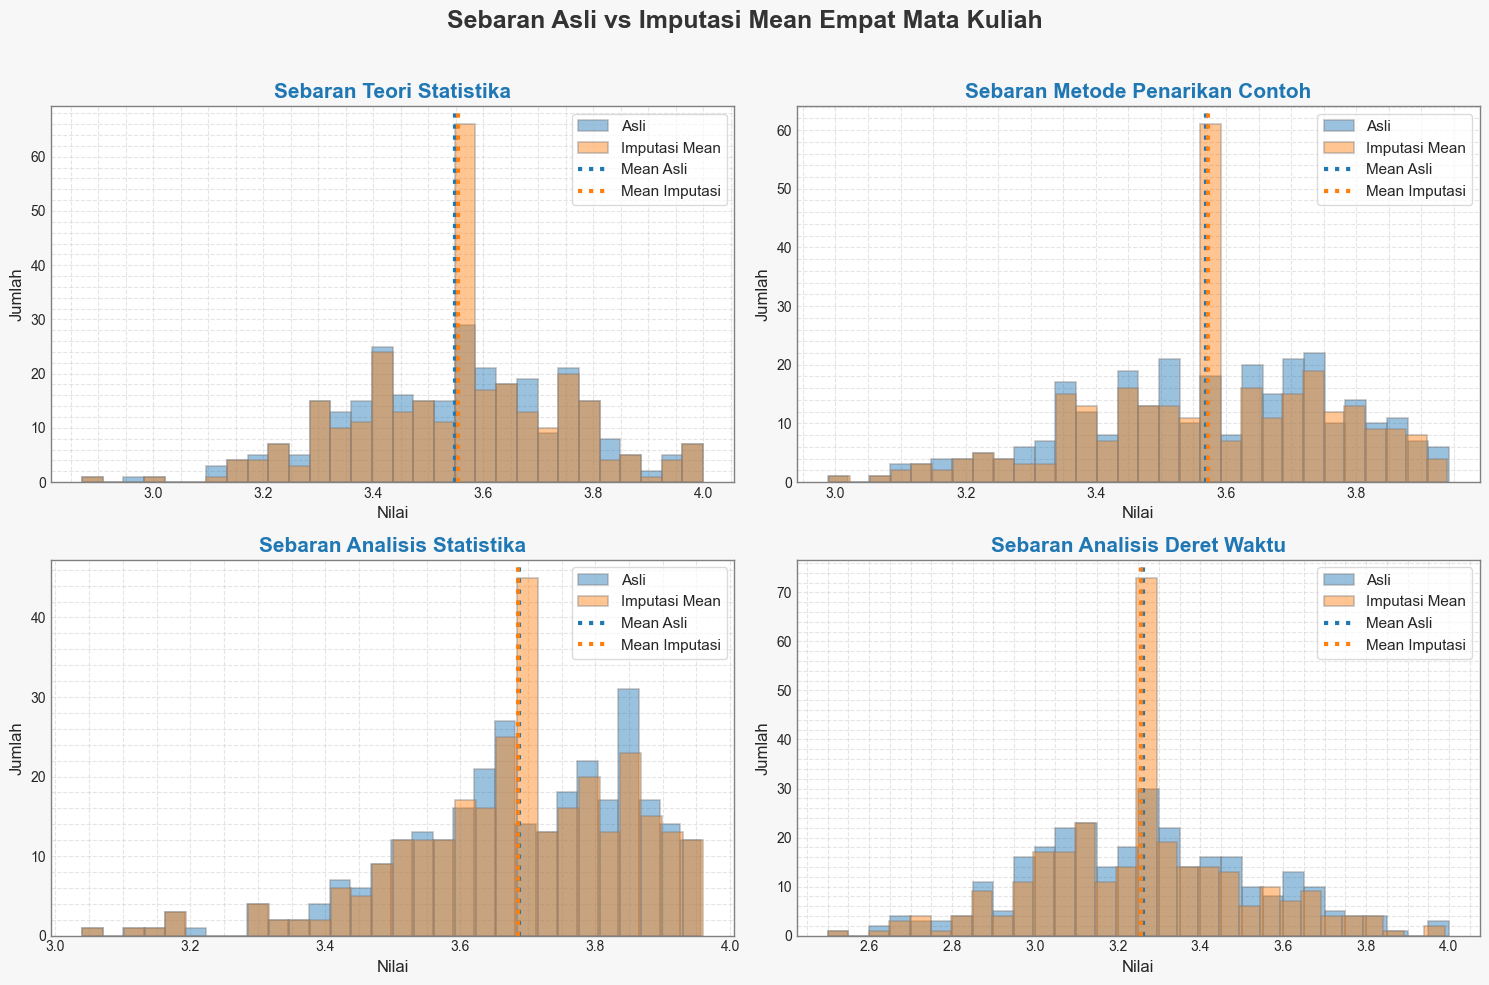

In [8]:
selected_courses = ["Teori Statistika", "Metode Penarikan Contoh", "Analisis Statistika", "Analisis Deret Waktu"]
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
colors = ["#1f77b4", "#ff7f0e"]

for ax, course in zip(axes.flatten(), selected_courses):
    ax.hist(df[course], bins=30, alpha=0.45, color=colors[0], label="Asli", edgecolor='gray', linewidth=1.2)
    ax.hist(df_mean_imputed[course], bins=30, alpha=0.45, color=colors[1], label="Imputasi Mean", edgecolor='gray', linewidth=1.2)
    ax.set_title(f"Sebaran {course}", fontsize=15, fontweight='bold', color=colors[0])
    ax.set_xlabel("Nilai", fontsize=12)
    ax.set_ylabel("Jumlah", fontsize=12)  # Ganti label Y
    ax.grid(True, linestyle='--', alpha=0.5, which='both')
    ax.minorticks_on()
    ax.axvline(df[course].mean(), color=colors[0], linestyle=':', linewidth=3, label="Mean Asli")
    ax.axvline(df_mean_imputed[course].mean(), color=colors[1], linestyle=':', linewidth=3, label="Mean Imputasi")
    leg = ax.legend(fontsize=11, frameon=True)
    leg.get_frame().set_alpha(0.7)

fig.patch.set_facecolor('#f7f7f7')
plt.suptitle("Sebaran Asli vs Imputasi Mean Empat Mata Kuliah", fontsize=18, fontweight='bold', color="#333")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Imputasi Median

## Def. Fungsi

In [9]:
df_median_imputed = df_missing.copy()

for col in courses:
    median_val = df_median_imputed[col].median(skipna=True)
    df_median_imputed[col] = df_median_imputed[col].fillna(median_val)

df_median_imputed["IPK"] = df_median_imputed[courses].mean(axis=1)
df_median_imputed["IPK"] = df_median_imputed["IPK"].clip(2.75, 3.95).round(2)
rmse_median_dict = {}
mae_median_dict = {}

for col in courses:
    missing_mask = df_missing[col].isna()
    if missing_mask.sum() > 0:
        rmse = np.sqrt(mean_squared_error(df.loc[missing_mask, col], df_median_imputed.loc[missing_mask, col]))
        mae = mean_absolute_error(df.loc[missing_mask, col], df_median_imputed.loc[missing_mask, col])
        rmse_median_dict[col] = rmse
        mae_median_dict[col] = mae
    else:
        rmse_median_dict[col] = 0.0
        mae_median_dict[col] = 0.0

rmse_median_avg = np.mean(list(rmse_median_dict.values()))
mae_median_avg = np.mean(list(mae_median_dict.values()))
result_table_median = pd.DataFrame({
    "RMSE": pd.Series(rmse_median_dict),
    "MAE": pd.Series(mae_median_dict)})
result_table_median.loc["Rata-rata"] = [rmse_median_avg, mae_median_avg]
display(result_table_median.round(3))

,RMSE,MAE
Teori Statistika,0.219,0.169
Pemrograman Statistika,0.612,0.565
Analisis Statistika,0.176,0.150
Analisis Deret Waktu,0.300,0.249
Analisis Data Kategorik,0.227,0.177
Metode Penarikan Contoh,0.210,0.173
Rancangan Percobaan,0.698,0.512
Analisis Data Spasial,0.204,0.167
Pemodelan Klasifikasi,0.311,0.250
Rata-rata,0.329,0.268


## Visualisasi Sebaran

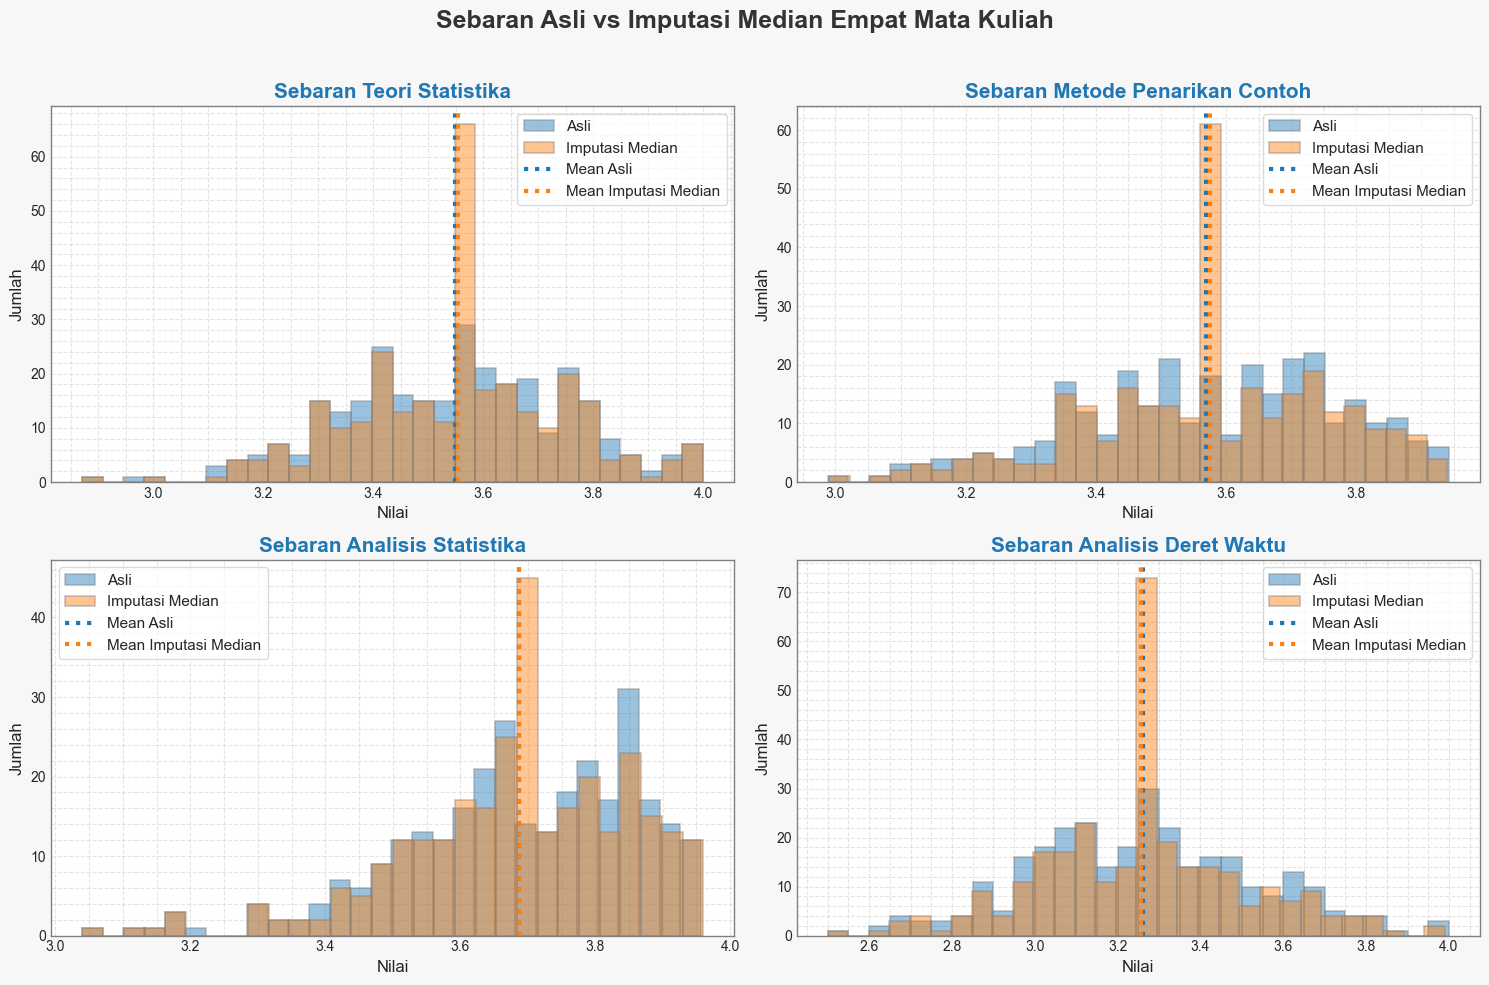

In [10]:
selected_courses = ["Teori Statistika", "Metode Penarikan Contoh", "Analisis Statistika", "Analisis Deret Waktu"]
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
colors = ["#1f77b4", "#ff7f0e"]  # Sama seperti plot mean

for ax, course in zip(axes.flatten(), selected_courses):
    ax.hist(df[course], bins=30, alpha=0.45, color=colors[0], label="Asli", edgecolor='gray', linewidth=1.2)
    ax.hist(df_median_imputed[course], bins=30, alpha=0.45, color=colors[1], label="Imputasi Median", edgecolor='gray', linewidth=1.2)
    ax.set_title(f"Sebaran {course}", fontsize=15, fontweight='bold', color=colors[0])
    ax.set_xlabel("Nilai", fontsize=12)
    ax.set_ylabel("Jumlah", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.5, which='both')
    ax.minorticks_on()
    ax.axvline(df[course].mean(), color=colors[0], linestyle=':', linewidth=3, label="Mean Asli")
    ax.axvline(df_median_imputed[course].mean(), color=colors[1], linestyle=':', linewidth=3, label="Mean Imputasi Median")
    leg = ax.legend(fontsize=11, frameon=True)
    leg.get_frame().set_alpha(0.7)

fig.patch.set_facecolor('#f7f7f7')
plt.suptitle("Sebaran Asli vs Imputasi Median Empat Mata Kuliah", fontsize=18, fontweight='bold', color="#333")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Imputasi KNN

## Def. Fungsi

In [11]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_missing[courses]), columns=courses)

rmse_knn_list = []
mae_knn_list = []
k_values = list(range(1, 30))

for k in k_values:
    knn_imputer = KNNImputer(n_neighbors=k)
    df_knn_scaled = pd.DataFrame(knn_imputer.fit_transform(df_scaled), columns=courses)
    df_knn_imputed = pd.DataFrame(scaler.inverse_transform(df_knn_scaled), columns=courses)
    df_knn_imputed["IPK"] = df_knn_imputed[courses].mean(axis=1)
    df_knn_imputed["IPK"] = df_knn_imputed["IPK"].clip(2.75, 3.95).round(2)

    rmse_dict, mae_dict = {}, {}
    for col in courses:
        missing_mask = df_missing[col].isna()
        if missing_mask.sum() > 0:
            rmse = np.sqrt(mean_squared_error(df.loc[missing_mask, col], df_knn_imputed.loc[missing_mask, col]))
            mae = mean_absolute_error(df.loc[missing_mask, col], df_knn_imputed.loc[missing_mask, col])
            rmse_dict[col] = rmse
            mae_dict[col] = mae
        else:
            rmse_dict[col] = 0.0
            mae_dict[col] = 0.0

    rmse_knn_list.append(np.mean(list(rmse_dict.values())))
    mae_knn_list.append(np.mean(list(mae_dict.values())))

Nilai k optimal berdasarkan kombinasi RMSE + MAE minimum: 27
RMSE (k=27): 0.3190
MAE  (k=27): 0.2651


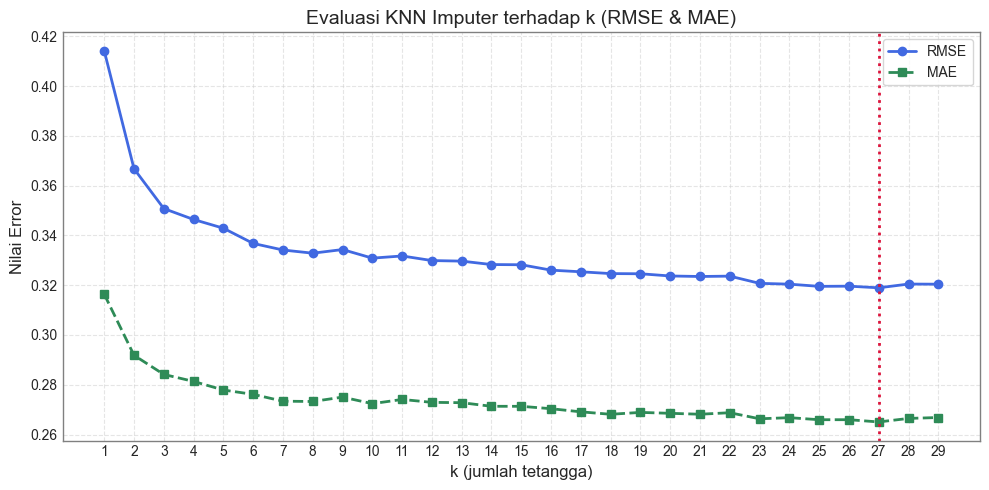

In [12]:
# Grid Search untuk k Optimal
combined_score = [rmse + mae for rmse, mae in zip(rmse_knn_list, mae_knn_list)]
k_optimal_idx = np.argmin(combined_score)
k_optimal = k_values[k_optimal_idx]

print(f"Nilai k optimal berdasarkan kombinasi RMSE + MAE minimum: {k_optimal}")
print(f"RMSE (k={k_optimal}): {rmse_knn_list[k_optimal_idx]:.4f}")
print(f"MAE  (k={k_optimal}): {mae_knn_list[k_optimal_idx]:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(k_values, rmse_knn_list, marker='o', linestyle='-', linewidth=2, color='royalblue', label='RMSE')
plt.plot(k_values, mae_knn_list, marker='s', linestyle='--', linewidth=2, color='seagreen', label='MAE')
plt.axvline(x=k_optimal, color='crimson', linestyle=':', linewidth=2)
plt.title("Evaluasi KNN Imputer terhadap k (RMSE & MAE)", fontsize=14)
plt.xlabel("k (jumlah tetangga)", fontsize=12)
plt.ylabel("Nilai Error", fontsize=12)
plt.xticks(k_values)
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()

In [13]:
# Tabel lengkap hasil imputasi dengan k optimal
knn_imputer_opt = KNNImputer(n_neighbors=k_optimal)
df_knn_scaled_opt = pd.DataFrame(knn_imputer_opt.fit_transform(df_scaled), columns=courses)
df_knn_imputed_opt = pd.DataFrame(scaler.inverse_transform(df_knn_scaled_opt), columns=courses)
df_knn_imputed_opt["IPK"] = df_knn_imputed_opt[courses].mean(axis=1)
df_knn_imputed_opt["IPK"] = df_knn_imputed_opt["IPK"].clip(2.75, 3.95).round(2)
print(f"Tabel lengkap hasil imputasi dengan k = {k_optimal}:")
display(df_knn_imputed_opt.round(2))

Tabel lengkap hasil imputasi dengan k = 27:


,Teori Statistika,Pemrograman Statistika,Analisis Statistika,Analisis Deret Waktu,Analisis Data Kategorik,Metode Penarikan Contoh,Rancangan Percobaan,Analisis Data Spasial,Pemodelan Klasifikasi,IPK
0,3.61,3.08,3.68,3.35,3.79,3.40,2.93,3.90,2.94,3.41
1,3.18,2.96,3.61,3.44,3.83,3.79,2.50,3.29,2.90,3.28
2,3.67,2.93,3.72,3.47,4.00,3.40,2.50,3.36,2.60,3.29
3,3.78,3.70,3.62,3.29,3.63,3.58,2.77,3.27,3.29,3.44
4,3.76,2.50,3.70,3.41,3.76,3.15,2.50,3.72,2.84,3.26
...,...,...,...,...,...,...,...,...,...,...
295,3.59,2.50,3.71,3.24,4.00,3.52,2.84,3.73,3.21,3.37
296,3.53,3.78,3.68,2.98,3.74,3.69,2.50,3.76,3.04,3.41
297,3.40,2.50,3.47,2.85,3.77,3.79,2.52,3.80,2.72,3.20
298,3.00,3.19,3.58,3.11,4.00,3.72,2.50,3.48,2.77,3.26


## Visualisasi Sebaran

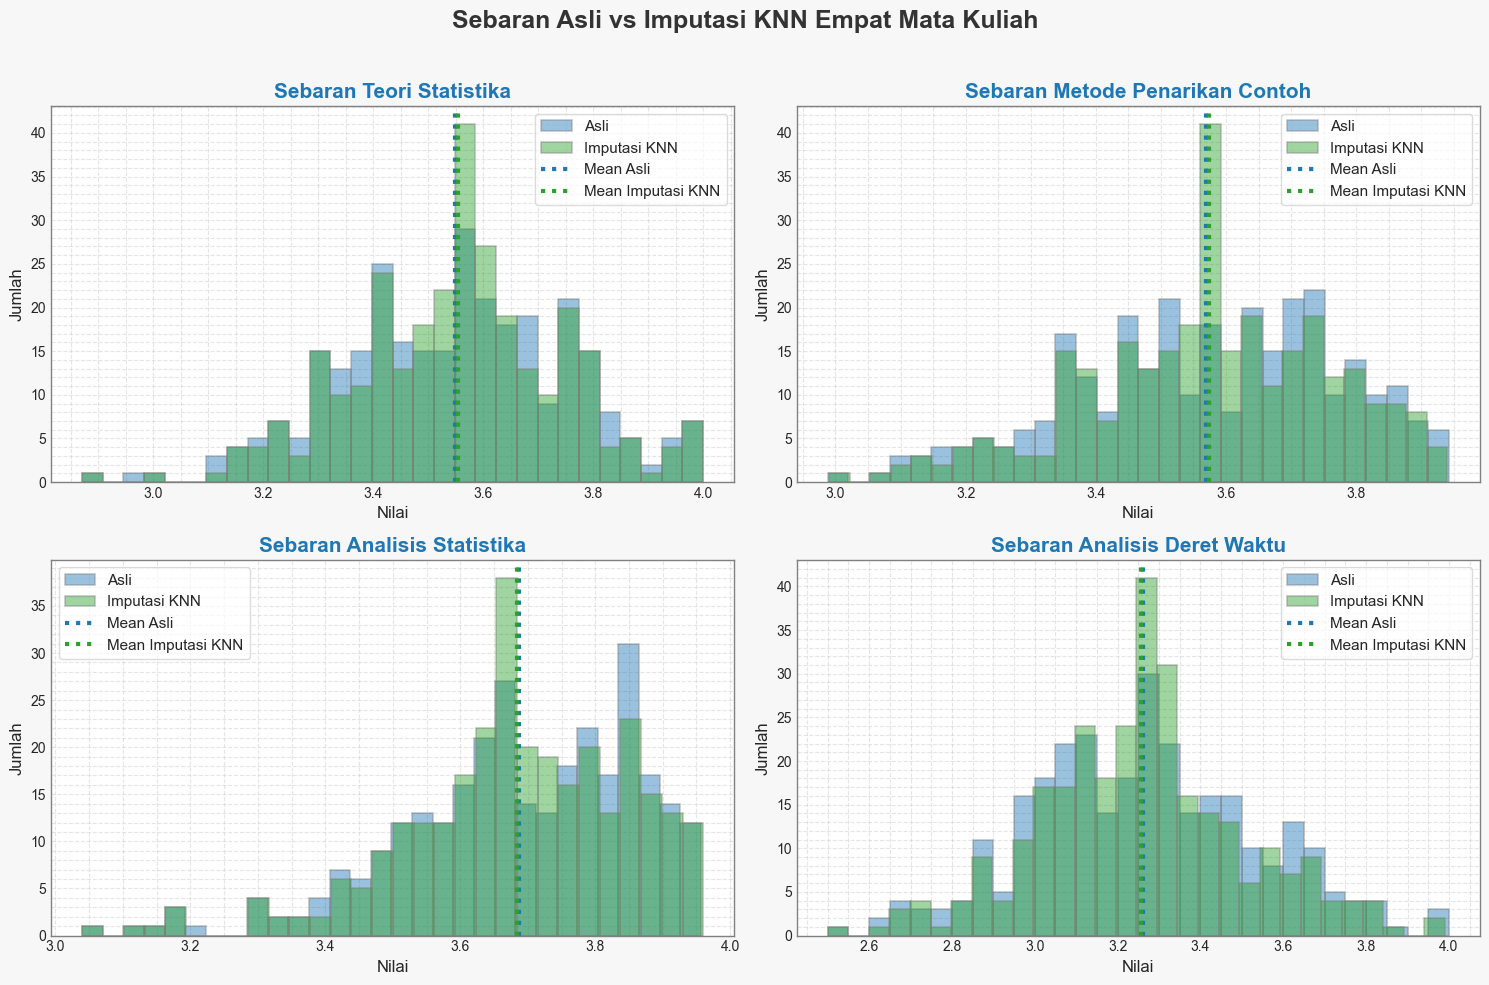

In [14]:
selected_courses = ["Teori Statistika", "Metode Penarikan Contoh", "Analisis Statistika", "Analisis Deret Waktu"]
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
colors = ["#1f77b4", "#2ca02c"] 

for ax, course in zip(axes.flatten(), selected_courses):
    ax.hist(df[course], bins=30, alpha=0.45, color=colors[0], label="Asli", edgecolor='gray', linewidth=1.2)
    ax.hist(df_knn_imputed_opt[course], bins=30, alpha=0.45, color=colors[1], label="Imputasi KNN", edgecolor='gray', linewidth=1.2)
    ax.set_title(f"Sebaran {course}", fontsize=15, fontweight='bold', color=colors[0])
    ax.set_xlabel("Nilai", fontsize=12)
    ax.set_ylabel("Jumlah", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.5, which='both')
    ax.minorticks_on()
    ax.axvline(df[course].mean(), color=colors[0], linestyle=':', linewidth=3, label="Mean Asli")
    ax.axvline(df_knn_imputed_opt[course].mean(), color=colors[1], linestyle=':', linewidth=3, label="Mean Imputasi KNN")
    leg = ax.legend(fontsize=11, frameon=True)
    leg.get_frame().set_alpha(0.7)

fig.patch.set_facecolor('#f7f7f7')
plt.suptitle("Sebaran Asli vs Imputasi KNN Empat Mata Kuliah", fontsize=18, fontweight='bold', color="#333")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Imputasi Fuzzy K-Means

## Def. Fungsi

In [15]:
def fuzzy_cmeans_impute(df_missing, courses, n_clusters=3, m=2, max_iter=150, error=1e-5):
    df_init = df_missing.copy()
    for col in courses:
        df_init[col].fillna(df_init[col].mean(), inplace=True)

    data = df_init[courses].values.T 
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        data, c=n_clusters, m=m, error=error, maxiter=max_iter, init=None)
    df_imputed = df_init.copy()

    for i, col in enumerate(courses):
        missing_idx = df_missing[col].isna()
        if missing_idx.sum() > 0:
            weights = u[:, missing_idx.values] 
            centroids = cntr[:, i].reshape(-1, 1)
            imputations = (centroids.T @ weights).flatten()
            df_imputed.loc[missing_idx, col] = imputations
    df_imputed["IPK"] = df_imputed[courses].mean(axis=1)
    df_imputed["IPK"] = df_imputed["IPK"].clip(2.75, 3.95).round(2)
    return df_imputed

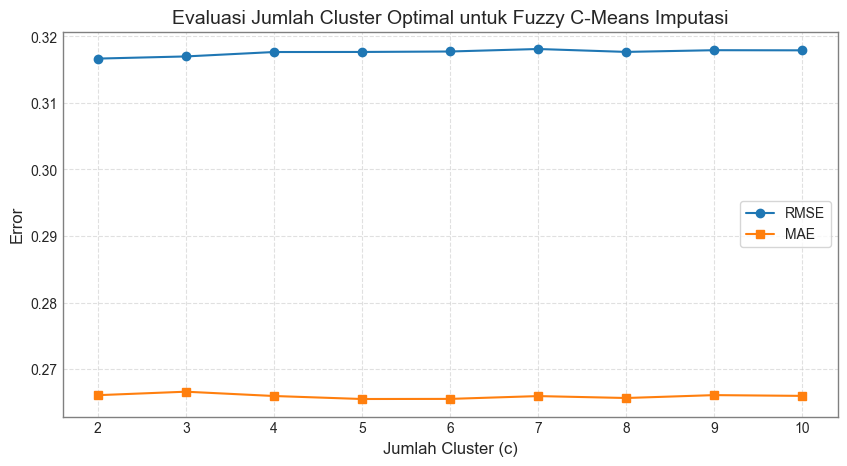

Jumlah cluster optimal: 2
RMSE minimal: 0.3167
MAE minimal: 0.2661


In [16]:
# Evaluasi jumlah c optimal
cluster_range = range(2, 11) 
rmse_list = []
mae_list = []

for c in cluster_range:
    df_imputed_c = fuzzy_cmeans_impute(df_missing, courses, n_clusters=c)

    rmse_dict, mae_dict = {}, {}
    for col in courses:
        missing_mask = df_missing[col].isna()
        if missing_mask.sum() > 0:
            rmse = np.sqrt(mean_squared_error(df.loc[missing_mask, col], df_imputed_c.loc[missing_mask, col]))
            mae = mean_absolute_error(df.loc[missing_mask, col], df_imputed_c.loc[missing_mask, col])
            rmse_dict[col] = rmse
            mae_dict[col] = mae
        else:
            rmse_dict[col] = 0.0
            mae_dict[col] = 0.0

    rmse_list.append(np.mean(list(rmse_dict.values())))
    mae_list.append(np.mean(list(mae_dict.values())))

plt.figure(figsize=(10,5))
plt.plot(cluster_range, rmse_list, marker='o', label='RMSE')
plt.plot(cluster_range, mae_list, marker='s', label='MAE')
plt.xlabel('Jumlah Cluster (c)')
plt.ylabel('Error')
plt.title('Evaluasi Jumlah Cluster Optimal untuk Fuzzy C-Means Imputasi')
plt.xticks(cluster_range)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

combined_score = [r + m for r, m in zip(rmse_list, mae_list)]
c_optimal = cluster_range[np.argmin(combined_score)]
print(f'Jumlah cluster optimal: {c_optimal}')
print(f'RMSE minimal: {rmse_list[np.argmin(combined_score)]:.4f}')
print(f'MAE minimal: {mae_list[np.argmin(combined_score)]:.4f}')

In [17]:
# Imputasi Fuzzy C-Means dengan c optimal
df_fuzzy_imputed = fuzzy_cmeans_impute(df_missing, courses, n_clusters=c_optimal)
print(f"Tabel hasil imputasi Fuzzy C-Means dengan c = {c_optimal}:")
display(df_fuzzy_imputed.round(2))

Tabel hasil imputasi Fuzzy C-Means dengan c = 2:


,Teori Statistika,Pemrograman Statistika,Analisis Statistika,Analisis Deret Waktu,Analisis Data Kategorik,Metode Penarikan Contoh,Rancangan Percobaan,Analisis Data Spasial,Pemodelan Klasifikasi,IPK
0,3.61,3.22,3.68,3.35,3.79,3.40,2.93,3.90,2.94,3.42
1,3.18,2.96,3.61,3.44,3.83,3.79,2.50,3.29,2.90,3.28
2,3.67,2.93,3.72,3.47,4.00,3.40,2.50,3.36,2.60,3.29
3,3.78,3.70,3.62,3.29,3.63,3.57,2.94,3.27,3.29,3.45
4,3.76,2.50,3.70,3.41,3.79,3.15,2.50,3.72,2.84,3.26
...,...,...,...,...,...,...,...,...,...,...
295,3.56,2.50,3.71,3.24,4.00,3.58,2.86,3.73,3.21,3.38
296,3.53,3.78,3.68,2.98,3.74,3.69,2.50,3.76,3.04,3.41
297,3.40,2.50,3.47,2.85,3.77,3.79,2.52,3.80,2.72,3.20
298,3.00,3.22,3.58,3.11,4.00,3.72,2.50,3.48,2.77,3.26


## Visualisasi Sebaran

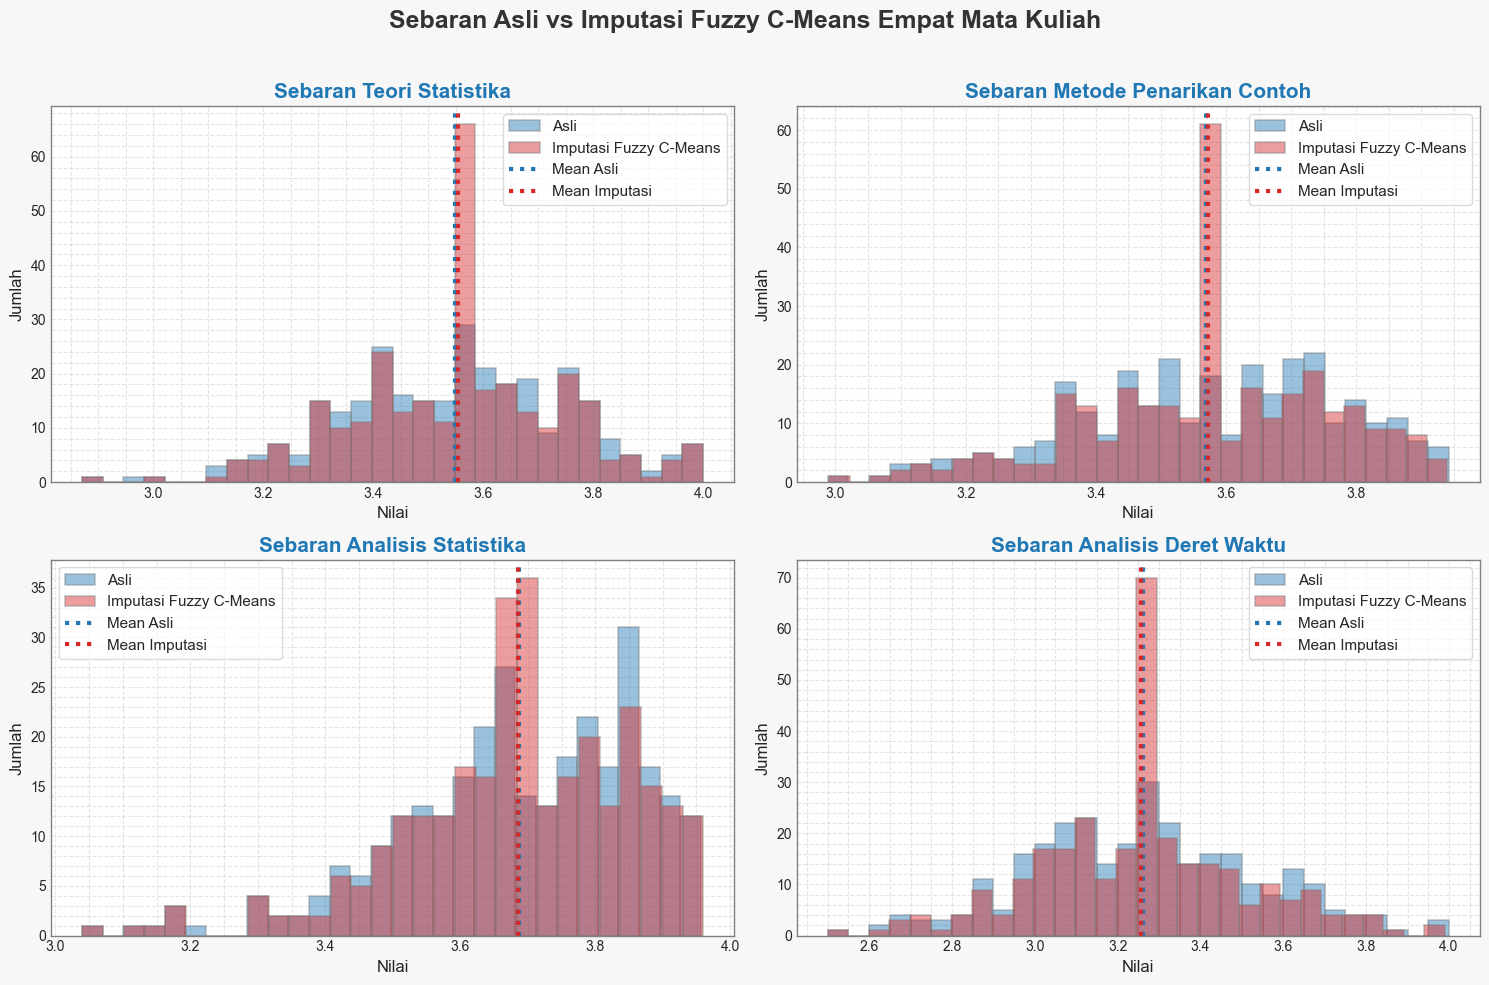

In [18]:
selected_courses = ["Teori Statistika", "Metode Penarikan Contoh", "Analisis Statistika", "Analisis Deret Waktu"]
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
colors = ["#1f77b4", "#d62728"]

for ax, course in zip(axes.flatten(), selected_courses):
    ax.hist(df[course], bins=30, alpha=0.45, color=colors[0], label="Asli", edgecolor='gray', linewidth=1.2)
    ax.hist(df_fuzzy_imputed[course], bins=30, alpha=0.45, color=colors[1], label="Imputasi Fuzzy C-Means", edgecolor='gray', linewidth=1.2)
    ax.set_title(f"Sebaran {course}", fontsize=15, fontweight='bold', color=colors[0])
    ax.set_xlabel("Nilai", fontsize=12)
    ax.set_ylabel("Jumlah", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.5, which='both')
    ax.minorticks_on()
    ax.axvline(df[course].mean(), color=colors[0], linestyle=':', linewidth=3, label="Mean Asli")
    ax.axvline(df_fuzzy_imputed[course].mean(), color=colors[1], linestyle=':', linewidth=3, label="Mean Imputasi")
    leg = ax.legend(fontsize=11, frameon=True)
    leg.get_frame().set_alpha(0.7)

fig.patch.set_facecolor('#f7f7f7')
plt.suptitle("Sebaran Asli vs Imputasi Fuzzy C-Means Empat Mata Kuliah", fontsize=18, fontweight='bold', color="#333")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Imputasi Isolation Forest

## Def. Fungsi

In [19]:
def isolation_forest_knn_impute(df_missing, df_true, courses, k=5, contamination=0.05):
    # Deteksi pencilan
    iso_forest = IsolationForest(contamination=contamination, random_state=17)
    df_filled = df_missing[courses].copy()
    df_filled = df_filled.fillna(df_filled.mean())
    iso_pred = iso_forest.fit_predict(df_filled)
    df_clean = df_missing.copy()
    df_clean['outlier'] = iso_pred
    for col in courses:
        df_clean.loc[df_clean['outlier'] == -1, col] = np.nan
    df_clean.drop(columns='outlier', inplace=True)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_clean[courses])
    knn_imputer = KNNImputer(n_neighbors=k)
    X_imputed_scaled = knn_imputer.fit_transform(X_scaled)
    X_imputed = pd.DataFrame(scaler.inverse_transform(X_imputed_scaled), columns=courses)
    X_imputed["IPK"] = X_imputed[courses].mean(axis=1).clip(2.75, 3.95).round(2)

    rmse_dict, mae_dict = {}, {}
    for col in courses:
        missing_mask = df_missing[col].isna()
        if missing_mask.sum() > 0:
            rmse = mean_squared_error(df_true.loc[missing_mask, col], X_imputed.loc[missing_mask, col], squared=False)
            mae = mean_absolute_error(df_true.loc[missing_mask, col], X_imputed.loc[missing_mask, col])
        else:
            rmse, mae = 0.0, 0.0
        rmse_dict[col] = rmse
        mae_dict[col] = mae

    rmse_avg = np.mean(list(rmse_dict.values()))
    mae_avg = np.mean(list(mae_dict.values()))
    return X_imputed, rmse_dict, mae_dict, rmse_avg, mae_avg

In [20]:
#  Evaluasi jumlah k optimal
rmse_avg_list, mae_avg_list, combined_list = [], [], []
k_values = range(2, 21) 

for k in k_values:
    _, _, _, rmse_avg, mae_avg = isolation_forest_knn_impute(df_missing, df, courses, k=k)
    rmse_avg_list.append(rmse_avg)
    mae_avg_list.append(mae_avg)
    combined_list.append(rmse_avg + mae_avg)

k_optimal_idx = np.argmin(combined_list)
k_optimal = k_values[k_optimal_idx]
print(f"✅ Nilai k optimal: {k_optimal}")
print(f"🔹 RMSE rata-rata: {rmse_avg_list[k_optimal_idx]:.4f}")
print(f"🔹 MAE rata-rata : {mae_avg_list[k_optimal_idx]:.4f}")

✅ Nilai k optimal: 18
🔹 RMSE rata-rata: 0.3245
🔹 MAE rata-rata : 0.2680


In [21]:
# Tabel lengkap hasil imputasi dengan k optimal
df_imputed_final, rmse_dict_final, mae_dict_final, _, _ = isolation_forest_knn_impute(df_missing, df, courses, k=k_optimal)
df_result = df_imputed_final.copy()
for col in courses:
    mask = df_missing[col].isna()
    df_result.loc[mask, col] = df_imputed_final.loc[mask, col]
df_result.round(2)

,Teori Statistika,Pemrograman Statistika,Analisis Statistika,Analisis Deret Waktu,Analisis Data Kategorik,Metode Penarikan Contoh,Rancangan Percobaan,Analisis Data Spasial,Pemodelan Klasifikasi,IPK
0,3.61,3.03,3.68,3.35,3.79,3.40,2.93,3.90,2.94,3.40
1,3.18,2.96,3.61,3.44,3.83,3.79,2.50,3.29,2.90,3.28
2,3.67,2.93,3.72,3.47,4.00,3.40,2.50,3.36,2.60,3.29
3,3.78,3.70,3.62,3.29,3.63,3.60,2.75,3.27,3.29,3.44
4,3.76,2.50,3.70,3.41,3.73,3.15,2.50,3.72,2.84,3.26
...,...,...,...,...,...,...,...,...,...,...
295,3.55,2.50,3.71,3.24,4.00,3.52,2.93,3.73,3.21,3.38
296,3.53,3.78,3.68,2.98,3.74,3.69,2.50,3.76,2.99,3.41
297,3.40,2.50,3.47,2.85,3.77,3.79,2.52,3.80,2.72,3.20
298,3.00,3.19,3.58,3.11,4.00,3.72,2.50,3.48,2.77,3.26


## Visualisasi Sebaran

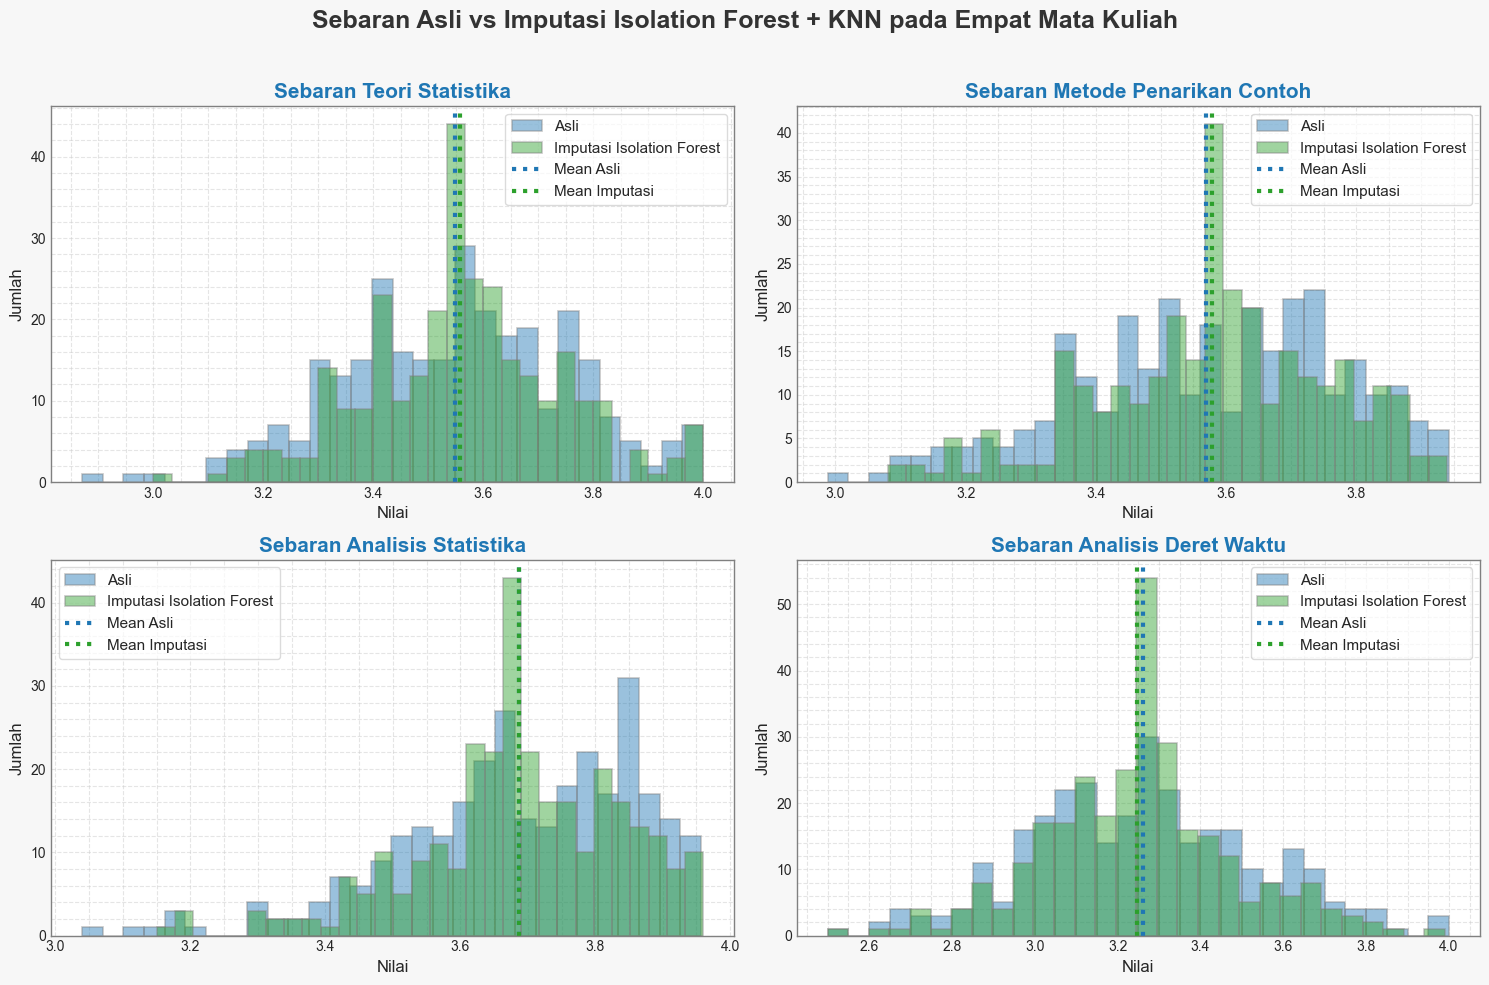

In [22]:
selected_courses = ["Teori Statistika", "Metode Penarikan Contoh", "Analisis Statistika", "Analisis Deret Waktu"]
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
colors = ["#1f77b4", "#2ca02c"]

for ax, course in zip(axes.flatten(), selected_courses):
    ax.hist(df[course], bins=30, alpha=0.45, color=colors[0], label="Asli", edgecolor='gray', linewidth=1.2)
    ax.hist(df_result[course], bins=30, alpha=0.45, color=colors[1], label="Imputasi Isolation Forest", edgecolor='gray', linewidth=1.2)
    ax.set_title(f"Sebaran {course}", fontsize=15, fontweight='bold', color=colors[0])
    ax.set_xlabel("Nilai", fontsize=12)
    ax.set_ylabel("Jumlah", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.5, which='both')
    ax.minorticks_on()
    ax.axvline(df[course].mean(), color=colors[0], linestyle=':', linewidth=3, label="Mean Asli")
    ax.axvline(df_result[course].mean(), color=colors[1], linestyle=':', linewidth=3, label="Mean Imputasi")
    leg = ax.legend(fontsize=11, frameon=True)
    leg.get_frame().set_alpha(0.7)

fig.patch.set_facecolor('#f7f7f7')
plt.suptitle("Sebaran Asli vs Imputasi Isolation Forest + KNN pada Empat Mata Kuliah", fontsize=18, fontweight='bold', color="#333")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Reinforcement Programming

## Def. Fungsi

In [23]:
scaler_rl = MinMaxScaler()
df_scaled_rl = pd.DataFrame(scaler_rl.fit_transform(df_missing[courses]), columns=courses)
actions = np.round(np.linspace(0, 1, 21), 2)
def reward_function(true_val, predicted_val):
    return -((true_val - predicted_val)**2)

In [24]:
# Reinforcement Learning untuk Imputasi
alpha = 0.1       # learning rate
gamma = 0.9       # discount factor
epsilon = 0.2     # exploration rate
n_episodes = 50   # episode per sel
q_tables = {} 

for col in courses:
    missing_indices = df_scaled_rl[df_scaled_rl[col].isna()].index
    if len(missing_indices) == 0:
        continue
    q_table = np.zeros((len(missing_indices), len(actions)))
    for episode in range(n_episodes):
        for i, idx in enumerate(missing_indices):
            if np.random.rand() < epsilon:
                a = np.random.randint(len(actions))
            else:
                a = np.argmax(q_table[i])
            action_val = actions[a]
            true_val = scaler_rl.transform(df.loc[[idx], courses])[0, courses.index(col)]
            reward = reward_function(true_val, action_val)
            q_table[i, a] += alpha * (reward + gamma * np.max(q_table[i]) - q_table[i, a])
    q_tables[col] = q_table

In [25]:
# Imputasi dengan Q-Learning
df_rl_imputed_scaled = df_scaled_rl.copy()

for col in courses:
    missing_indices = df_scaled_rl[df_scaled_rl[col].isna()].index
    if col in q_tables:
        q_table = q_tables[col]
        for i, idx in enumerate(missing_indices):
            best_action = np.argmax(q_table[i])
            df_rl_imputed_scaled.loc[idx, col] = actions[best_action]

df_rl_imputed = pd.DataFrame(scaler_rl.inverse_transform(df_rl_imputed_scaled), columns=courses)
df_rl_imputed["IPK"] = df_rl_imputed[courses].mean(axis=1).clip(2.75, 3.95).round(2)

In [26]:
# Evaluasi Imputasi Reinforcement Learning
rmse_dict, mae_dict = {}, {}
for col in courses:
    missing_mask = df_missing[col].isna()
    if missing_mask.sum() > 0:
        rmse = mean_squared_error(df.loc[missing_mask, col], df_rl_imputed.loc[missing_mask, col], squared=False)
        mae = mean_absolute_error(df.loc[missing_mask, col], df_rl_imputed.loc[missing_mask, col])
        rmse_dict[col] = rmse
        mae_dict[col] = mae
    else:
        rmse_dict[col] = 0.0
        mae_dict[col] = 0.0

rmse_avg = np.mean(list(rmse_dict.values()))
mae_avg = np.mean(list(mae_dict.values()))
print("📌 Evaluasi Reinforcement Learning Imputation")
print(f"🔹 RMSE Rata-rata: {rmse_avg:.4f}")
print(f"🔹 MAE  Rata-rata: {mae_avg:.4f}")

📌 Evaluasi Reinforcement Learning Imputation
🔹 RMSE Rata-rata: 0.0228
🔹 MAE  Rata-rata: 0.0152


## Visualisasi Sebaran

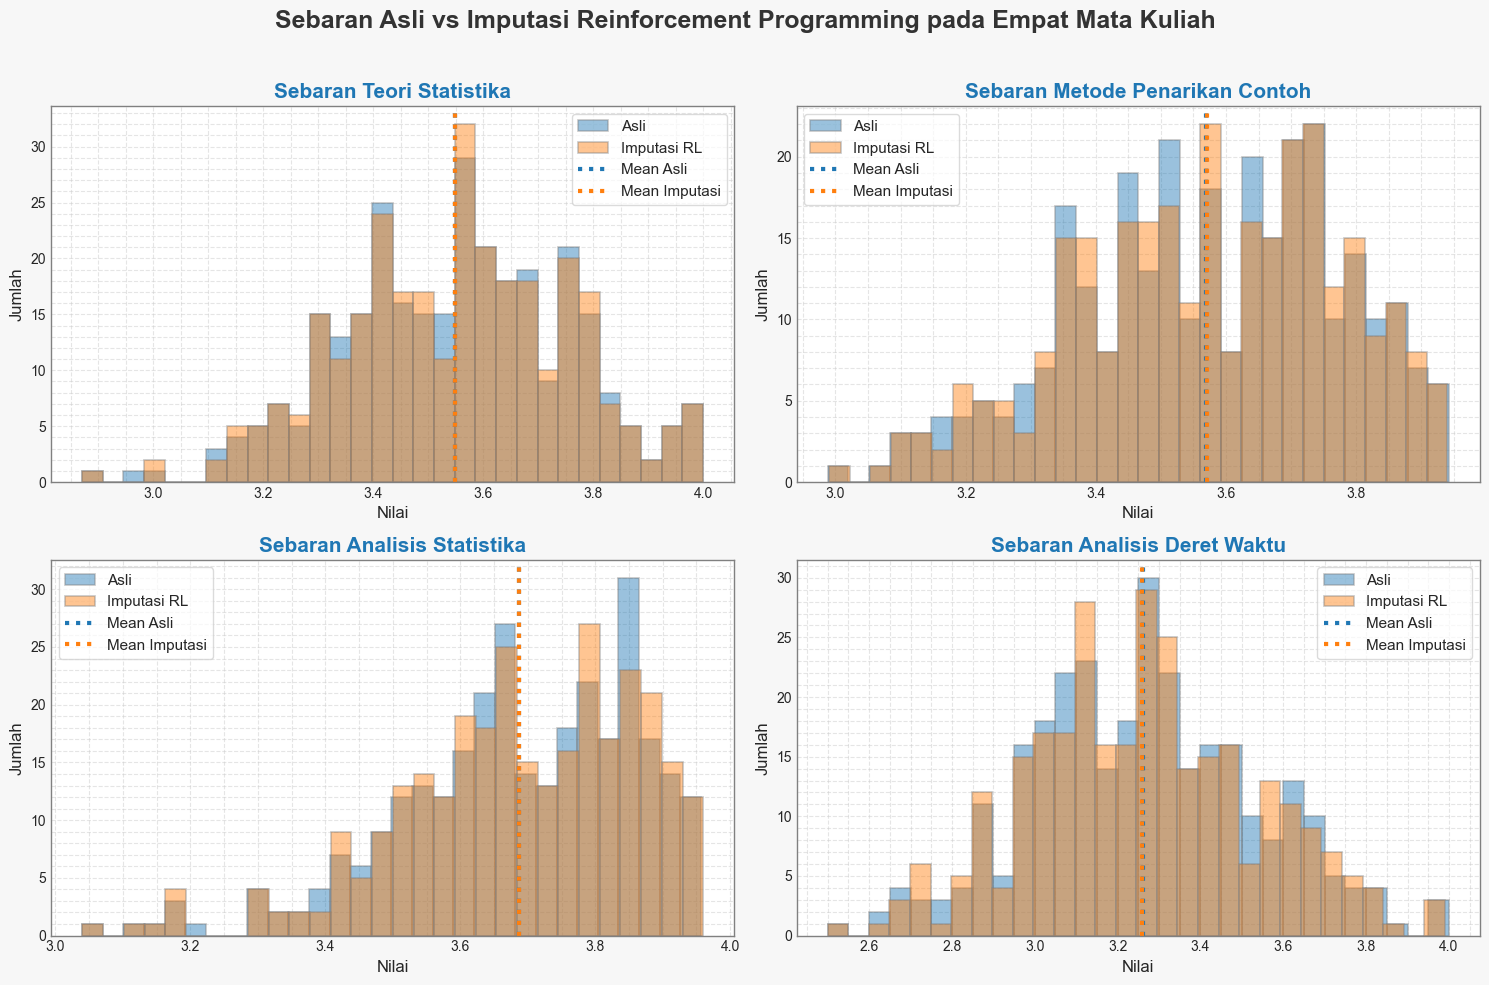

In [27]:
selected_courses = ["Teori Statistika", "Metode Penarikan Contoh", "Analisis Statistika", "Analisis Deret Waktu"]
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
colors = ["#1f77b4", "#ff7f0e"] 

for ax, course in zip(axes.flatten(), selected_courses):
    ax.hist(df[course], bins=30, alpha=0.45, color=colors[0], label="Asli", edgecolor='gray', linewidth=1.2)
    ax.hist(df_rl_imputed[course], bins=30, alpha=0.45, color=colors[1], label="Imputasi RL", edgecolor='gray', linewidth=1.2)

    ax.set_title(f"Sebaran {course}", fontsize=15, fontweight='bold', color=colors[0])
    ax.set_xlabel("Nilai", fontsize=12)
    ax.set_ylabel("Jumlah", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.5, which='both')
    ax.minorticks_on()

    # Garis rata-rata
    ax.axvline(df[course].mean(), color=colors[0], linestyle=':', linewidth=3, label="Mean Asli")
    ax.axvline(df_rl_imputed[course].mean(), color=colors[1], linestyle=':', linewidth=3, label="Mean Imputasi")

    leg = ax.legend(fontsize=11, frameon=True)
    leg.get_frame().set_alpha(0.7)

# Background dan layout
fig.patch.set_facecolor('#f7f7f7')
plt.suptitle("Sebaran Asli vs Imputasi Reinforcement Programming pada Empat Mata Kuliah",
             fontsize=18, fontweight='bold', color="#333")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [28]:
# Tabel lengkap hasil imputasi Reinforcement Learning
df_result_rl = df_rl_imputed.copy()
df_result_rl.round(2)

,Teori Statistika,Pemrograman Statistika,Analisis Statistika,Analisis Deret Waktu,Analisis Data Kategorik,Metode Penarikan Contoh,Rancangan Percobaan,Analisis Data Spasial,Pemodelan Klasifikasi,IPK
0,3.61,4.00,3.68,3.35,3.79,3.40,2.93,3.90,2.94,3.51
1,3.18,2.96,3.61,3.44,3.83,3.79,2.50,3.29,2.90,3.28
2,3.67,2.93,3.72,3.47,4.00,3.40,2.50,3.36,2.60,3.29
3,3.78,3.70,3.62,3.29,3.63,3.70,2.50,3.27,3.29,3.42
4,3.76,2.50,3.70,3.41,3.64,3.15,2.50,3.72,2.84,3.25
...,...,...,...,...,...,...,...,...,...,...
295,3.83,2.50,3.71,3.24,4.00,3.56,4.00,3.73,3.21,3.53
296,3.53,3.78,3.78,2.98,3.74,3.69,2.50,3.76,2.71,3.39
297,3.40,2.50,3.47,2.85,3.77,3.79,2.52,3.80,2.72,3.20
298,3.00,2.80,3.58,3.11,4.00,3.72,2.50,3.48,2.77,3.22
